## Introduction
RATP is a voxel based model for computing plant irradiation balance along with transpiration and photosynthesis.

RATP voxels must be filled with a list of points, each associated with a leaf surface and nitrogen content. This list of points can be obtained from different ways: full digitalization of a real plant, Lidar scan completed with plant area density estimation for each voxel, or through the creation of artifical plants. 

The theory behind RATP can be found in the online documentation and the original publication: https://doi.org/10.1046/j.1365-3040.2001.00694.x

In this tutorial we discover the different inputs necessary to run RATP (all read from existing files in this tutorial), launch a simulation and have a look at some outputs.

author: cyril.bozonnet@inrae.fr

### Inputs
- Grid file: it contains parameters used to set-up the voxel grid (number of cells, dimensions, ..).
- Leaves data: a list of (x,y,z) coordinates along with leaf area and nitrogen content, for each vegetation type within the grid.
- Meteo data: a list of meteorological data (global & diffusive PAR and NIR radiation fluxes, air temperature, CO2 concentration, wind speed,..) sampled at a regular frequency.
- Vegetation list: the list of the different vegetation entities/types that are present in the grid.
- Vegetation data (one file per vegetation entity): containing physical and physiological parameters such as informations about foliage dispersion within voxels, leaf inclination angles, boundary layer conductances, and parameters for Jarvis' and Farquhar's models.
- Skyvault data: the list of light sources used to describe the skyvault for diffusive radiation computations

### Outputs
Pandas data frames containing various informations at the voxel scale (shaded/sunlit temperature, PAR, shaded/sunlit photosynthesis & transpiration,..) or at the tree scale (tree photosynthesis, tree transpiration,..).

The voxel data can be viewed using the dedicated PyRATP viewer (requires the PyVista library), or exported as a vtk file for external visualisation.


In [1]:
# import all required librairies
import pandas
import os
import numpy as np
from openalea.ratp.skyvault import Skyvault
from openalea.ratp.grid import Grid
from openalea.ratp.vegetation import Vegetation
from openalea.ratp.micrometeo import MicroMeteo
from openalea.ratp.runratp import runRATP
from openalea.ratp.RATP2VTK import ratpvoxels2vtk, extract_dataframe, pyratpviewer
import matplotlib.pyplot as plt

In [5]:
# Now define the different input file names
datafolder = "data_pyratp"
leaf_file = "LOD6juin0_2.vgx"
grid_file =  "gridfromVGX_0_5m.grd"
meteo_file = 'Forcage_sansTROU1_PARdirPOSITIF.mto'
skyvault_file = 'skyvaultsoc.skv'
vegetation_list = 'vegetationa_2004.vfn'

## (optional) Have a look at the input files 


In [6]:
# first define some useful function
def display_file(file_path,nlines=5,encoder ='latin-1'):
    """
    Loads a text file and displays the first nlines lines.

    Args:
        file_path (str): Path to the text file.
        nlines (int): number of lines to display, Default=5.
        encoder (str): encoding type, Default=latin-1.
    """
    try:
        with open(file_path, 'r', encoding=encoder) as file:
            lines = file.readlines()
            for i, line in enumerate(lines[:nlines], 1):
                print(f"{i}: {line.strip()}")
    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found.")
    except Exception as e:
        print(f"An error occurred: {e}")


In [7]:
# have a look at the leaf file
display_file(os.path.join(datafolder, leaf_file))

1: Obj	EchX	EchY	EchZ	TransX	TransY	TransZ	RotX	RotY	RotZ	R	G	B	Shoot	TdC
2: 11.0000	15.9525	13.6540	1.0000	458.8470	391.3363	-283.8826	4.0452	-22.7496	159.3558	0.0000	191.0000	0.0000	1.0000	1.0000
3: 11.0000	15.9525	13.6540	1.0000	467.1060	391.3392	-288.5748	-8.6709	-15.2595	-36.3157	0.0000	242.0000	0.0000	1.0000	1.0000
4: 11.0000	15.9525	13.6540	1.0000	462.0930	399.6030	-287.5786	29.0249	-4.3163	143.6843	0.0000	32.0000	0.0000	1.0000	1.0000
5: 11.0000	15.9525	13.6540	1.0000	469.3630	397.8648	-292.6140	-28.6058	-37.3282	-45.4842	0.0000	252.0000	0.0000	1.0000	1.0000


It is a Vegestar file that contains different informations about leaves position and orientation. It will be read by PyRATP and turned into a list of coordinates, leaf surface and nitrogen content. One can also directly read such list, as shown in ```example/run_pyratp.py```.


In [8]:
# have a look at the grid file. It defines the 3D voxel grid.
display_file(os.path.join(datafolder, grid_file),10)


1: 11 10 12 ! nx, ny,nz
2: 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 ! dx, dy, dz (nz+1 times)
3: 0.08404499999999998 0.2980714999999997 -2.3868764999999996 ! x_orig, y_orig, z_orig
4: 44.0 0.0 0.0  ! latitude, longitude timezone (hours)
5: 0.0 ! angle (Â°) between axis X+ and North
6: 0 ! offset between canopy units along Y-axis
7: 1 ! number of vegetation entities in the 3D grid
8: 2 0.075 0.2 ! number of wavebands, soil reflectance for each waveband


In [9]:
# have a look at the meteo file
display_file(os.path.join(datafolder, meteo_file),10)

1: day	hour	PARglob	PARdif	NIRglob	NIRdif	Ratmos	Tsol	Tair	Eair	CO2air	Wind
2: 164	8	358.4	61	264.1	45	359	36	20.8	1419.1	36.8	1
3: 164	9	431.5	56.6	320.7	42.1	365.5	39.1	22.3	1455.2	36.4	1.2
4: 164	10	485.5	51	363.8	38.2	372.1	42.6	23.7	1446.4	36.3	1.7
5: 164	11	520.5	56.6	400.5	43.5	372.7	44.3	25	1313.5	36.2	0.9
6: 164	12	515	65	398.2	50.2	377.2	38.3	25.6	1210.5	36.1	1.1
7: 164	13	493.3	75.1	374.5	57	383.2	38	26	1163.5	36	1.2
8: 164	14	453.9	70.4	334.9	52	388.1	41.7	26.5	1216.3	36	1.2
9: 164	15	327.6	94.7	227.9	61.9	393.6	39.2	26.8	1265.7	35.9	1.1
10: 164	16	255.8	131.7	183.7	94.3	395.9	30.1	25.9	1270.4	36	2.2


In [10]:
# have a look at the vegetation list
display_file(os.path.join(datafolder, vegetation_list))

1: 1 pommier1_PARmoy12_TA.veg


We see that informations about vegetation element number 1 are stored in a .veg file. Let's have a look at it:


In [11]:
veg_file = "pommier1_PARmoy12_TA.veg"
display_file(os.path.join(datafolder, veg_file),20)

1: 0.5765! Parameter of foliage dispersion within voxels (1: random, <1: clumped; >1: regular)
2: 10! Number of leaf inclination angle classes
3: 0.0731	0.2120	0.3062	0.2585	0.1475	0.0027	0.0000	0.0000	0.0000	0.0000	! Calculé d'après digit pommiers suisses 2004
4: 2! Number of wavelength bands
5: 0.051	0.479!	PAR	NIR	scattering coefficients
6: 0.01	0.0071!	Parameters of boundary layer conductance : ga = A1 wind_speed + A2
7: 0.	4.12e-3! Parameters of Jarvis model: effect of leaf nitrogen content : gsmax = A1 Na + A2
8: 1	3	-1.223e-7	7.579e-4	1.0e-4! Parameters of Jarvis model: effect of leaf PAR irradiance : fgsPAR = f(PAR, µmol m-2 s-1)
9: 1	3	2.32e-4	-4.02e-2	2.07! Parameters of Jarvis model: effect of air CO2 pressure : fgsPAR = f(CA, Pa)
10: 5	4	0.97498	1.	25.01445	11.150015!Parameters of Jarvis model: effect of leaf temperature : fgsPAR = f(LT, °C)
11: -0.266e-3	1.3764	1500.! Parameters of Jarvis model: effect of leaf surface VPD : gsmax = A1 VPD (Pa) + A2, A3=treshold
12: 20.0	6.

## Load inputs into PyRATP

In [12]:
# Create grid file
fn = os.path.join(datafolder, grid_file)
g = Grid()
g = Grid.read(fn) # g is a Fortran object containing all grid characteristics

# Read leaf area data from digitalisation (Vegestar file)
coeff_allometric = 1 # allometric coefficient for leaf area calculation
e, x, y, z, s, n = Grid.readVgx(os.path.join(datafolder, leaf_file), coeff_allometric) # entity number, x, y ,z, surface, nitrogen

data_pyratp/LOD6juin0_2.vgx
VEGE3D OK


The vegestar file has been transformed into a list of coordinates,leaf area and nitrogen content values. One could also directly read a text file containing these data, see ```example/run_pyratp.py```. We can have a look at the leaf coordinates in a 3D space:

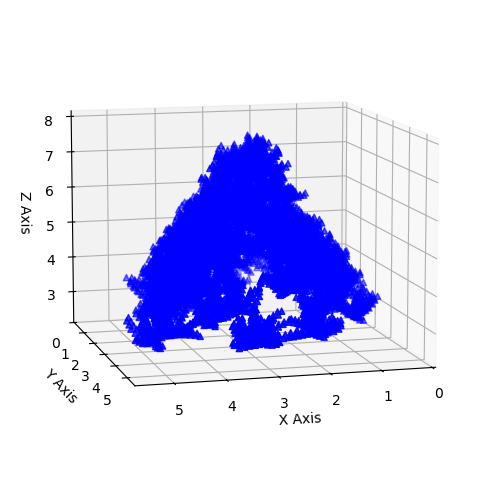

In [14]:
# Create a 3D plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot the leaf coordinates
ax.scatter(x, y, z, c='b', marker='^')

# Labels
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')

# Enable grid
ax.grid(True)

# Set the viewing angle 
ax.view_init(elev=10, azim=75)

# Show the plot
plt.show()

Now we can use these coordinates to fill up the grid with the leaf area  and nitrogen content values!

In [15]:
# fill up the grid
g, matching = Grid.fill_1(e, x, y, z, s, n, g)

In [16]:
# Now we can read all other files (meteo, skyvault and vegetation) 

#  meteo
fn = os.path.join(datafolder, meteo_file)
truesolartime = True # solar or local time
met = MicroMeteo.read(fn, truesolartime)

# sky
fn = os.path.join(datafolder, skyvault_file )
sky = Skyvault.read(fn)

# vegetation
fn = os.path.join(datafolder, vegetation_list)
veg = Vegetation.read(fn)

MICROMETEO OK
SKYVAULT OK
VEGETATION OK


## Run a simulation

In [17]:
# RATP: doALL (irradiation balance + photosynthesis + transpiration)
# check ```example/run_pyratp.py``` for an example with DoIrradiation only
res_spatial, res_tree = runRATP.DoAll(g, veg, sky, met) # should take less than a minute!

Progress:   0.13%
Progress:   6.38%
Progress:  12.76%
Progress:  19.13%
Progress:  25.51%
Progress:  31.89%
Progress:  38.27%
Progress:  44.64%
Progress:  51.02%
Progress:  57.40%
Progress:  63.78%
Progress:  70.15%
Progress:  76.53%
Progress:  82.91%
Progress:  89.29%
Progress:  95.66%
 COMPUTATIONS COMPLETED


## Extract the results, plot and export to vtk

In [18]:
# the results are stored in 2 variables : one at the voxel scale, and one at the tree scale, for each iteration
# we can extract the different results as 2 Pandas dataframe:
# first, the results at the voxel scale
dfvox =  pandas.DataFrame({'VegetationType':res_spatial[:,0],
                    'Iteration':res_spatial[:,1],
                    'day':res_spatial[:,2],
                    'hour':res_spatial[:,3],
                    'AirTemperature':res_spatial[:,4],
                    'VoxelId':res_spatial[:,5],
                    'ShadedTemp':res_spatial[:,6],
                    'SunlitTemp':res_spatial[:,7],
                    'STARDirect':res_spatial[:,8],
                    'STARSky':res_spatial[:,9],
                    'ShadedPhoto':res_spatial[:,10],
                    'SunlitPhoto':res_spatial[:,11],
                    'ShadedTranspi':res_spatial[:,12],
                    'SunlitTranspi':res_spatial[:,13],
                    'ShadedArea':res_spatial[:,14],
                    'SunlitArea':res_spatial[:,15],
                    'ShadedGs':res_spatial[:,16],
                    'SunlitGs':res_spatial[:,17],
                    'ShadedAbsordbedPAR':res_spatial[:,18] / 4.6,
                    'SunlitAbsordbedPAR':res_spatial[:,19]/ 4.6,
                    'ShadedAbsordbedNIR':res_spatial[:,20] / 4.6,
                    'SunlitAbsordbedNIR':res_spatial[:,21] / 4.6,
                    'Area': res_spatial[:,14] + res_spatial[:,15],
                    'PAR': (res_spatial[:,18] * res_spatial[:,14] + res_spatial[:,19] * res_spatial[:,15]) / (res_spatial[:,14] + res_spatial[:,15])/4.6, 
                    })
print(dfvox.head())



   VegetationType  Iteration    day  hour  AirTemperature  VoxelId  \
0             1.0        1.0  164.0   8.0       20.799999      1.0   
1             1.0        1.0  164.0   8.0       20.799999      2.0   
2             1.0        1.0  164.0   8.0       20.799999      3.0   
3             1.0        1.0  164.0   8.0       20.799999      4.0   
4             1.0        1.0  164.0   8.0       20.799999      5.0   

   ShadedTemp  SunlitTemp  STARDirect   STARSky  ...  ShadedArea  SunlitArea  \
0   19.415968   21.679701    0.004639  0.161574  ...    0.326271    0.004905   
1   19.912445   22.135607    0.092610  0.195926  ...    0.587532    0.246644   
2   20.138557   22.345430    0.002386  0.072436  ...    1.750483    0.013437   
3   20.351616   22.539978    0.041342  0.145397  ...    0.954985    0.145217   
4   19.708347   21.948580    0.018223  0.152635  ...    0.139244    0.008602   

   ShadedGs  SunlitGs  ShadedAbsordbedPAR  SunlitAbsordbedPAR  \
0  0.000207  0.001409            

In [19]:
# then the results at the tree scale

dftree = pandas.DataFrame({'Iteration':res_tree[:,0],
                       'day':res_tree[:,1],
                       'hour':res_tree[:,2],
                       'VegetationType':res_tree[:,3],
                       'TotalIrradiation':res_tree[:,4],
                       'AirTemperature':res_tree[:,5],
                       'TreePhotosynthesis':res_tree[:,6],
                       'TreeTranspiration': res_tree[:,7],
                       'LeafSurfaceArea': res_tree[:,8],
                       })

print(dftree.head())

   Iteration    day  hour  VegetationType  TotalIrradiation  AirTemperature  \
0        1.0  164.0   8.0             1.0        622.500000       20.799999   
1        2.0  164.0   9.0             1.0        752.200012       22.299999   
2        3.0  164.0  10.0             1.0        849.299988       23.700001   
3        4.0  164.0  11.0             1.0        921.000000       25.000000   
4        5.0  164.0  12.0             1.0        913.200012       25.600000   

   TreePhotosynthesis  TreeTranspiration  LeafSurfaceArea  
0            2.680423           0.223904       253.597305  
1            2.156503           0.224730       253.597305  
2            1.971942           0.260929       253.597305  
3            1.859720           0.307866       253.597305  
4            1.692277           0.300776       253.597305  


In [20]:
# you can save these dataframes for a later use (visualisation or analysis)
from datetime import datetime

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
dfvox.to_csv(f'dfvox_{timestamp}.csv', index=False)
dftree.to_csv(f'dftree_{timestamp}.csv', index=False)

Text(0, 0.5, 'TreePhotosynthesis [mol CO2 / s / m2]')

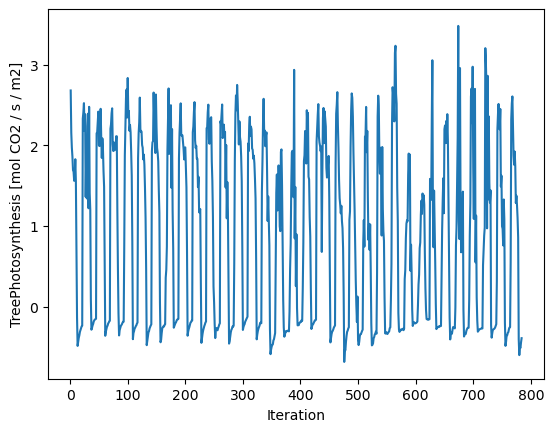

In [21]:
# we can show a simple plot of a variable at the tree scale
var2plot = 'TreePhotosynthesis'
y_label = 'TreePhotosynthesis [mol CO2 / s / m2]'

plt.figure()
plt.plot(dftree['Iteration'],dftree[var2plot])
plt.xlabel('Iteration')
plt.ylabel(y_label)


## Visualisation

PyRATP has a dedicated viewer based on the PyVista library. It allows visualizing the full 3D voxel data with a fully interactive control on the variable, day, hour, and entity. For it to run you need to install the PyVista library using ```pip install pyvista```. You can also run ```View_data_frame.py``` after saving the data frames to run the viewer alone.

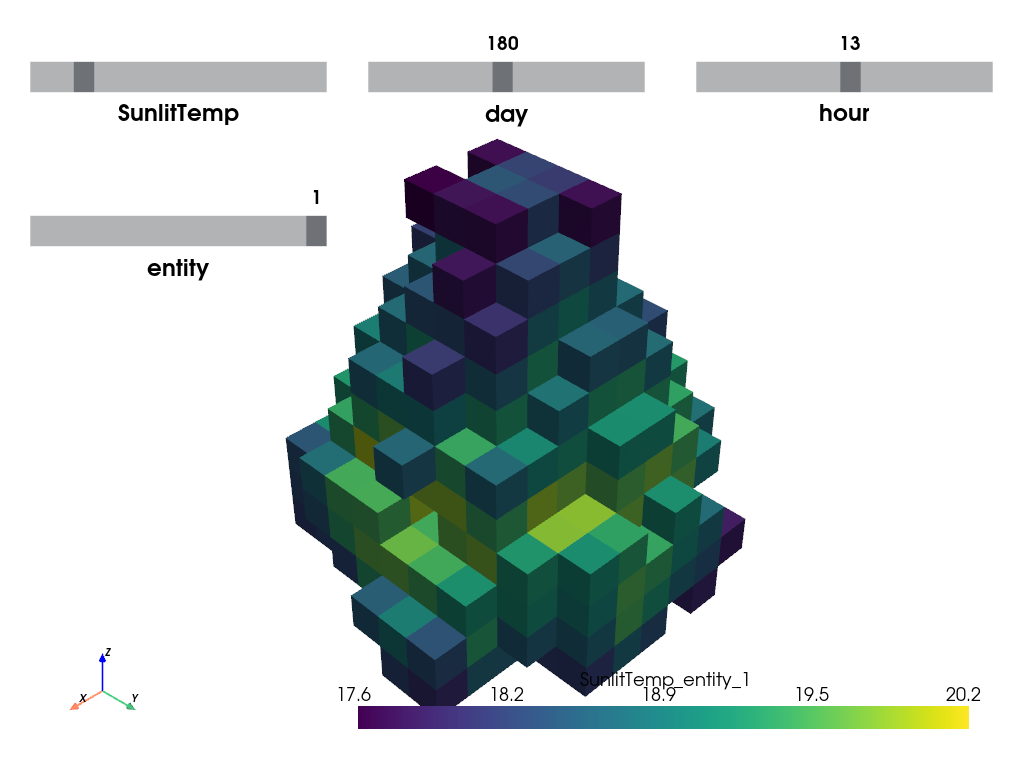

In [23]:
pyratpviewer(g, dfvox) # no interactivity in notebooks!

In [19]:
# You can extract a specific data at a given time to VTK format in order to view it 
# with an external program (e.g., Paraview) or using again Pyvista, see example/view_vtk.py
DayToExtract = 192
HourToExtract = 12
ColToExtract = 'PAR'

outputname = 'data_'+ColToExtract+'_day'+str(DayToExtract)+'hour'+str(HourToExtract)+'.vtk'

array = extract_dataframe(dfvox, ColToExtract, DayToExtract, HourToExtract)

# write VTK file
ratpvoxels2vtk(g, array,ColToExtract,outputname)

And this is the end of this tutorial dedicated to the basics of PyRATP! 